# Import Libraries



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools

#Model Class Definition

In [ ]:
#create a model class
class Model(nn.Module):
  #Input (Tasks) random array of 9 units
  def __init__(self, in_tasks=9, in_stim=9, hidden=100, output=9, bias_weight=-2):
    super().__init__()

    #Set Parameters
    self.bias_weight = bias_weight   # default bias weight


    self.task_hidden=nn.Linear(in_tasks, hidden)    #input layer(tasks) --> hidden layer
    self.stim_hidden=nn.Linear(in_stim, hidden)     #input layer(stimuls) --> hidden layer
    self.task_out=nn.Linear(in_tasks, output)       #Input Layer(tasks) --> output layer
    self.hidden_out=nn.Linear(hidden, output)       #hidden layer --> output layer


    self.task_hidden.weight=nn.Parameter(torch.FloatTensor(hidden, in_tasks).uniform_(-0.1, 0.1))   #input(tasks)-->hidden  weight
    self.task_out.weight=nn.Parameter(torch.FloatTensor(output, in_tasks).uniform_(-0.1, 0.1))      #input(tasks) --> output weight
    self.stim_hidden.weight=nn.Parameter(torch.FloatTensor(hidden, in_stim).uniform_(-0.1, 0.1))    #input(stimulus) -->hidden weight
    self.hidden_out.weight=nn.Parameter(torch.FloatTensor(output, hidden).uniform_(-0.1, 0.1))      #hidden-->output  weight


    self.task_hidden.bias=nn.Parameter(torch.ones(hidden) * bias_weight)                   #hidden layer bias
    self.hidden_out.bias=nn.Parameter(torch.ones(output) * bias_weight)                    #output layer bias

  def forward(self, taskData, stimulusData):

    h_act=torch.sigmoid(self.task_hidden(taskData)+self.stim_hidden(stimulusData))   #hidden layer activation
    out_act= torch.sigmoid(self.hidden_out(h_act)+self.task_out(taskData))           #output layer activation

    return h_act, out_act

    # #Check sizes
    # print("h_act shape:", h_act.shape)
    # print("out_act shape:", out_act.shape)


#Define plot_losses Function for Learning curves plotting

In [ ]:
def plot_losses(losses, title):
    plt.plot(losses)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()

#Define Multitask Model Dataset

In [ ]:
# Generate training data
def generate_dataset_multitask():

  #Generate stimulus data
    stimulusData = torch.tensor([ [0, 0, 1, 0, 0, 1, 0, 0, 1],
                                [0, 0, 1, 0, 0, 1, 0, 1, 0],
                                [0, 0, 1, 0, 0, 1, 1, 0, 0],
                                [0, 0, 1, 0, 1, 0, 0, 0, 1],
                                [0, 0, 1, 0, 1, 0, 0, 1, 0],
                                [0, 0, 1, 0, 1, 0, 1, 0, 0],
                                [0, 0, 1, 1, 0, 0, 0, 0, 1],
                                [0, 0, 1, 1, 0, 0, 0, 1, 0],
                                [0, 0, 1, 1, 0, 0, 1, 0, 0],
                                [0, 1, 0, 0, 0, 1, 0, 0, 1],
                                [0, 1, 0, 0, 1, 0, 0, 0, 1],
                                [0, 1, 0, 0, 0, 1, 0, 1, 0],
                                [0, 1, 0, 0, 0, 1, 1, 0, 0],
                                [0, 1, 0, 0, 1, 0, 0, 1, 0],
                                [0, 1, 0, 0, 1, 0, 1, 0, 0],
                                [0, 1, 0, 1, 0, 0, 0, 0, 1],
                                [0, 1, 0, 1, 0, 0, 0, 1, 0],
                                [0, 1, 0, 1, 0, 0, 1, 0, 0],
                                [1, 0, 0, 0, 0, 1, 0, 0, 1],
                                [1, 0, 0, 0, 0, 1, 0, 1, 0],
                                [1, 0, 0, 0, 0, 1, 1, 0, 0],
                                [1, 0, 0, 0, 1, 0, 0, 0, 1],
                                [1, 0, 0, 1, 0, 0, 0, 0, 1],
                                [1, 0, 0, 1, 0, 0, 0, 1, 0],
                                [1, 0, 0, 1, 0, 0, 1, 0, 0],
                                [1, 0, 0, 0, 1, 0, 0, 1, 0],
                                [1, 0, 0, 0, 1, 0, 1, 0, 0]
                                                           ] *20 , dtype=torch.float)


# Generate task data
    taskDatapattern = torch.tensor([
    [1, 1, 1, 0, 0, 0, 0, 0, 0] , #Task 1
    [1, 1, 0, 1, 0, 0, 0, 0, 0] , #Task 2
    [1, 1, 0, 0, 1, 0, 0, 0, 0] , #Task 3
    [1, 1, 0, 0, 0, 1, 0, 0, 0] , #Task 4
    [1, 1, 0, 0, 0, 0, 1, 0, 0] , #Task 5
    [1, 1, 0, 0, 0, 0, 0, 1, 0] , #Task 6
    [1, 1, 0, 0, 0, 0, 0, 0, 1] , #Task 7
    [1, 0, 1, 0, 0, 0, 0, 0, 1] , #Task 8
    [1, 0, 0, 1, 0, 0, 0, 0, 1] , #Task 9
    [1, 0, 0, 0, 1, 0, 0, 0, 1] , #Task 10
    [1, 0, 0, 0, 0, 1, 0, 0, 1] , #Task 11
    [1, 0, 0, 0, 0, 0, 1, 0, 1] , #Task 12
    [1, 0, 0, 0, 0, 0, 0, 1, 1] , #Task 13
    [1, 0, 0, 0, 0, 0, 0, 1, 1] , #Task 14
    [0, 1, 0, 0, 0, 0, 0, 1, 1] , #Task 15
    [0, 0, 1, 0, 0, 0, 0, 1, 1] , #Task 16
    [0, 0, 0, 1, 0, 0, 0, 1, 1] , #Task 17
    [0, 0, 0, 0, 1, 0, 0, 1, 1] , #Task 18
    [0, 0, 0, 0, 0, 1, 0, 1, 1] , #Task 19
    [0, 0, 0, 0, 0, 0, 1, 1, 1] ] #Task 20

                          , dtype=torch.float)

    taskData = torch.cat([torch.stack([row] * 27) for row in taskDatapattern])

#Generate target data
    targetData = torch.zeros((540,9), dtype=torch.float)


    for i in range(len(targetData)):
       for j in range(0, len(targetData[i]), 3):
        if taskData[i, j:j+3].sum() > 0:
          targetData[i, j:j+3] = stimulusData[i, j:j+3]


    return stimulusData, taskData, targetData


#Define Single Task Model Dataset

In [ ]:
# Generate validation data (Single task Pattern)

def generate_dataset_multitask_V():

  #Stimulus
   stimulusData_V = torch.tensor([ [0, 0, 1, 0, 0, 1, 0, 0, 1],
                                [0, 0, 1, 0, 0, 1, 0, 1, 0],
                                [0, 0, 1, 0, 0, 1, 1, 0, 0],
                                [0, 0, 1, 0, 1, 0, 0, 0, 1],
                                [0, 0, 1, 0, 1, 0, 0, 1, 0],
                                [0, 0, 1, 0, 1, 0, 1, 0, 0],
                                [0, 0, 1, 1, 0, 0, 0, 0, 1],
                                [0, 0, 1, 1, 0, 0, 0, 1, 0],
                                [0, 0, 1, 1, 0, 0, 1, 0, 0],
                                [0, 1, 0, 0, 0, 1, 0, 0, 1],
                                [0, 1, 0, 0, 1, 0, 0, 0, 1],
                                [0, 1, 0, 0, 0, 1, 0, 1, 0],
                                [0, 1, 0, 0, 0, 1, 1, 0, 0],
                                [0, 1, 0, 0, 1, 0, 0, 1, 0],
                                [0, 1, 0, 0, 1, 0, 1, 0, 0],
                                [0, 1, 0, 1, 0, 0, 0, 0, 1],
                                [0, 1, 0, 1, 0, 0, 0, 1, 0],
                                [0, 1, 0, 1, 0, 0, 1, 0, 0],
                                [1, 0, 0, 0, 0, 1, 0, 0, 1],
                                [1, 0, 0, 0, 0, 1, 0, 1, 0],
                                [1, 0, 0, 0, 0, 1, 1, 0, 0],
                                [1, 0, 0, 0, 1, 0, 0, 0, 1],
                                [1, 0, 0, 1, 0, 0, 0, 0, 1],
                                [1, 0, 0, 1, 0, 0, 0, 1, 0],
                                [1, 0, 0, 1, 0, 0, 1, 0, 0],
                                [1, 0, 0, 0, 1, 0, 0, 1, 0],
                                [1, 0, 0, 0, 1, 0, 1, 0, 0]
                                                           ] *9 , dtype=torch.float)

#Task
   SingleTask_V = torch.tensor ([
     [1, 0, 0, 0, 0, 0, 0, 0, 0] , #Task 1
     [0, 1, 0, 0, 0, 0, 0, 0, 0] , #Task 2
     [0, 0, 1, 0, 0, 0, 0, 0, 0] , #Task 3
     [0, 0, 0, 1, 0, 0, 0, 0, 0] , #Task 4
     [0, 0, 0, 0, 1, 0, 0, 0, 0] , #Task 5
     [0, 0, 0, 0, 0, 1, 0, 0, 0] , #Task 6
     [0, 0, 0, 0, 0, 0, 1, 0, 0] , #Task 7
     [0, 0, 0, 0, 0, 0, 0, 1, 0] , #Task 8
     [0, 0, 0, 0, 0, 0, 0, 0, 1] ]  #Task 9
                                         , dtype=torch.float)


   taskData_V = torch.cat([torch.stack([row] * 27) for row in SingleTask_V])

#Target
   targetData_V = torch.zeros((243,9), dtype=torch.float)

   for i in range(len(targetData)):
     if taskData[i, :3].sum() > 0:
         targetData[i, :3] = stimulusData[i, :3]
     elif taskData[i, 3:6].sum() > 0:
         targetData[i, 3:6] = stimulusData[i, 3:6]
     elif taskData[i, 6:].sum() > 0:
         targetData[i, 6:] = stimulusData[i, 6:]


   return stimulusData_V, taskData_V, targetData_V


#Generate Data

In [ ]:
(stimulusData, taskData, targetData)  = generate_dataset_multitask()   #Generate traning multitask data

In [ ]:
stimulusData_V, taskData_V, targetData_V = generate_dataset_multitask_V() #Generate validation Single task data

#Create an instance from Model

In [ ]:
#create an instance for Model
model= Model()

In [ ]:
model(taskData, stimulusData) #Model outputs

(tensor([[0.1005, 0.1234, 0.1082,  ..., 0.1341, 0.1244, 0.1016],
         [0.0979, 0.1347, 0.1124,  ..., 0.1298, 0.1166, 0.0929],
         [0.0992, 0.1218, 0.1100,  ..., 0.1330, 0.1076, 0.0901],
         ...,
         [0.0969, 0.1507, 0.1134,  ..., 0.1208, 0.1051, 0.0951],
         [0.1007, 0.1532, 0.1134,  ..., 0.1203, 0.1251, 0.1055],
         [0.1019, 0.1389, 0.1110,  ..., 0.1232, 0.1155, 0.1023]],
        grad_fn=<SigmoidBackward0>),
 tensor([[0.0803, 0.1126, 0.1707,  ..., 0.0935, 0.1525, 0.0994],
         [0.0800, 0.1125, 0.1712,  ..., 0.0937, 0.1527, 0.0992],
         [0.0807, 0.1123, 0.1713,  ..., 0.0934, 0.1529, 0.0987],
         ...,
         [0.0937, 0.1091, 0.1555,  ..., 0.0830, 0.1351, 0.1082],
         [0.0936, 0.1099, 0.1556,  ..., 0.0828, 0.1343, 0.1084],
         [0.0944, 0.1097, 0.1557,  ..., 0.0825, 0.1345, 0.1080]],
        grad_fn=<SigmoidBackward0>))

#Traning Functions Definition
TrainOnline Function: Uses backpopagation for Supervised Learning


In [ ]:
#Train Online Method using back propagation
def trainOnline(model, taskData, stimulusData, targetData, iterations, thresh=0.0001, lr=0.1):

    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    MSE_log = []

    with tqdm(total=iterations) as pbar:
        for i in range(iterations):
            optimizer.zero_grad()
            h_act, out_act = model(taskData, stimulusData)
            loss = criterion(out_act, targetData)
            loss.backward()
            optimizer.step()
            MSE = loss.item()
            MSE_log.append(MSE)

            if MSE < thresh:
                break

            pbar.set_postfix({'MSE': MSE})
            pbar.update(1)

    return MSE_log


#Supervised Learning Loop

In [ ]:
#Run TrainOnline Function using backpropagation
MSE_log = trainOnline(model, stimulusData, taskData, targetData, 200000)

100%|██████████| 200000/200000 [23:09<00:00, 143.92it/s, MSE=0.000187]


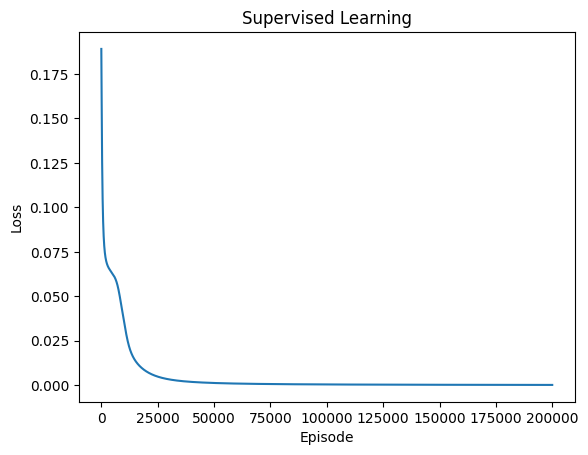

In [ ]:
#Plot learning curve
single_log=plot_losses(MSE_log,'Supervised Learning')

#Reinforcement Learning
Using Reinforce Algorithm

In [ ]:
#Reinforcement learning using REINFORCE algorithm
def reinforce_train(model, optimizer, taskData, stimulusData, reward):

    optimizer.zero_grad()

    _, outputs = model(taskData, stimulusData)
    log_probs = torch.log(outputs.squeeze(0))

    # REINFORCE loss
    loss = -log_probs * reward
    loss = loss.mean()
    #reward = torch.sum(outputs * targetData)
    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
#Reinforce traning Loop

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #Define the Optimizer

# Define training loop
def train_Rein(num_episodes=1000, log_interval=1):
    losses = []  # To store losses at each episode
    for episode in range(1, num_episodes + 1):

        # Forward pass
        _, outputs = model(taskData, stimulusData)

        # Define reward
        reward = torch.sum(outputs * targetData)

        # Train using REINFORCE
        loss = reinforce_train(model, optimizer, taskData, stimulusData, reward)
        losses.append(loss)
        #Logging
        if episode % log_interval == 0:
            print(f"Episode {episode}/{num_episodes} | Loss: {loss:.3f}")
    plot_losses(losses,'Reinforce Learning')


Episode 1/1000 | Loss: 270.959
Episode 2/1000 | Loss: 268.484
Episode 3/1000 | Loss: 266.012
Episode 4/1000 | Loss: 263.544
Episode 5/1000 | Loss: 261.080
Episode 6/1000 | Loss: 258.617
Episode 7/1000 | Loss: 256.157
Episode 8/1000 | Loss: 253.698
Episode 9/1000 | Loss: 251.240
Episode 10/1000 | Loss: 248.782
Episode 11/1000 | Loss: 246.324
Episode 12/1000 | Loss: 243.865
Episode 13/1000 | Loss: 241.405
Episode 14/1000 | Loss: 238.944
Episode 15/1000 | Loss: 236.480
Episode 16/1000 | Loss: 234.013
Episode 17/1000 | Loss: 231.544
Episode 18/1000 | Loss: 229.071
Episode 19/1000 | Loss: 226.595
Episode 20/1000 | Loss: 224.115
Episode 21/1000 | Loss: 221.631
Episode 22/1000 | Loss: 219.142
Episode 23/1000 | Loss: 216.649
Episode 24/1000 | Loss: 214.151
Episode 25/1000 | Loss: 211.649
Episode 26/1000 | Loss: 209.141
Episode 27/1000 | Loss: 206.628
Episode 28/1000 | Loss: 204.111
Episode 29/1000 | Loss: 201.588
Episode 30/1000 | Loss: 199.060
Episode 31/1000 | Loss: 196.528
Episode 32/1000 |

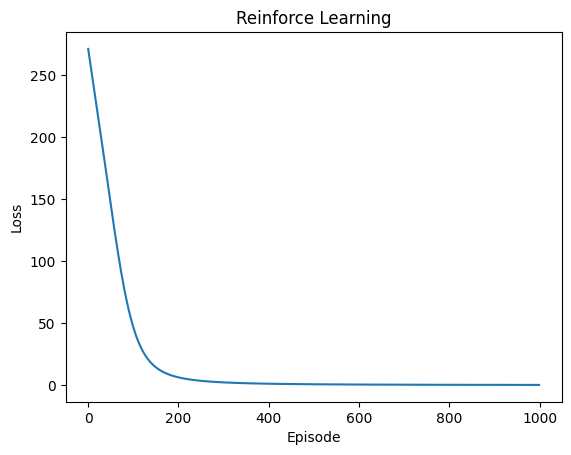

In [ ]:
# Train the model using Reinforce
train_Rein()

#Evaluation

In [ ]:
#Define Evalutae function
def evaluate(model, taskData_V, stimulusData_V, targetData_V):
    model.eval()
    with torch.no_grad():
        _, val_output = model(taskData_V, stimulusData_V)
        criterion = nn.MSELoss()
        val_loss = criterion(val_output, targetData_V).item()

    model.train()
    return val_loss, val_output

In [ ]:
val_loss, val_output= evaluate(model, taskData_V, stimulusData_V, targetData_V)

In [ ]:
print(val_loss)

2.173693580687086e-08


In [ ]:
print(val_output)

tensor([[1.0716e-04, 1.5376e-04, 1.3687e-04,  ..., 2.1228e-04, 1.3854e-04,
         1.4710e-04],
        [9.6691e-05, 1.4049e-04, 1.2752e-04,  ..., 1.9187e-04, 1.2335e-04,
         1.3810e-04],
        [1.0219e-04, 1.4736e-04, 1.3139e-04,  ..., 1.9737e-04, 1.3155e-04,
         1.4615e-04],
        ...,
        [1.1112e-04, 1.6176e-04, 1.2266e-04,  ..., 1.8722e-04, 1.3253e-04,
         1.6526e-04],
        [1.0203e-04, 1.5622e-04, 1.1873e-04,  ..., 1.7942e-04, 1.2367e-04,
         1.6007e-04],
        [1.0790e-04, 1.6399e-04, 1.2227e-04,  ..., 1.8446e-04, 1.3204e-04,
         1.6955e-04]])
